In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')

In [3]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Data-preprocessing -> Geospatial and time data

## Calculate the distance traveled
The <a href='https://en.wikipedia.org/wiki/Haversine_formula'>haversine formula</a> calculates the distance on a sphere between two sets of GPS coordinates.<br>
Here we assign latitude values with $\varphi$ (phi) and longitude with $\lambda$ (lambda).

The distance formula works out to

${\displaystyle d=2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\:\cos(\varphi _{2})\:\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$

where

$\begin{split} r&: \textrm {radius of the sphere (Earth's radius averages 6371 km)}\\
\varphi_1, \varphi_2&: \textrm {latitudes of point 1 and point 2}\\
\lambda_1, \lambda_2&: \textrm {longitudes of point 1 and point 2}\end{split}$

In [4]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371 # average radius of Earth in kilometers
    
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r*c)
    
    return d

In [5]:
df['dist_km'] = haversine_distance(df,'pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')

/Users/williamtun/opt/anaconda3/envs/data/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df['dist_km']

0       66.317333
1      244.722934
2             NaN
3             NaN
4      136.359115
          ...    
994           NaN
995           NaN
996           NaN
997    356.014132
998           NaN
Name: dist_km, Length: 999, dtype: float64

In [12]:
df = df.dropna().reset_index(drop=True)

In [15]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                549 non-null    object             
 1   fare_amount        549 non-null    float64            
 2   pickup_datetime    549 non-null    datetime64[ns, UTC]
 3   pickup_longitude   549 non-null    float64            
 4   pickup_latitude    549 non-null    float64            
 5   dropoff_longitude  549 non-null    float64            
 6   dropoff_latitude   549 non-null    float64            
 7   passenger_count    549 non-null    int64              
 8   dist_km            549 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(1)
memory usage: 38.7+ KB


In [18]:
 df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [19]:
df['Hour'] = df['EDTdate'].dt.hour

In [20]:
df['AMorPM'] = np.where(df['Hour']>12, 'am', 'pm')

In [22]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")

In [23]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,66.317333,2009-06-15 13:26:21+00:00,13,am,Mon
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,244.722934,2010-01-05 12:52:16+00:00,12,pm,Tue
2,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,136.359115,2010-03-09 03:51:00+00:00,3,pm,Tue
3,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1,213.711504,2011-01-06 05:50:45+00:00,5,pm,Thu
4,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00+00:00,-73.980002,40.751662,-73.973802,40.764842,1,100.412752,2012-11-20 16:35:00+00:00,16,am,Tue


In [24]:
## Separate categorical from continuous columns

In [25]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']  # this column contains the labels

In [28]:
# Pandas offers a category dtype for converting categorical values to numerical codes. 
# A dataset containing months of the year will be assigned 12 codes, one for each month. 
# These will usually be the integers 0 to 11. Pandas replaces the column values with codes, 
# and retains an index list of category values.

for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [27]:
df.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPM                          category
Weekday                         category
dtype: object

In [30]:
# Weekday is not of type category, along with AMorPM and Hour
df['Weekday'].head()

0    Mon
1    Tue
2    Tue
3    Thu
4    Tue
Name: Weekday, dtype: category
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [32]:
df['Weekday'].cat.codes.values

array([1, 5, 5, 4, 5, 1, 3, 1, 4, 5, 2, 6, 2, 5, 4, 1, 5, 1, 5, 2, 3, 2,
       4, 1, 5, 2, 6, 0, 6, 5, 5, 2, 6, 0, 2, 6, 1, 4, 1, 6, 0, 1, 1, 0,
       5, 3, 1, 2, 0, 6, 1, 4, 1, 4, 5, 0, 0, 6, 0, 4, 5, 1, 3, 5, 4, 0,
       4, 3, 0, 2, 3, 4, 0, 5, 1, 2, 3, 5, 0, 2, 2, 2, 1, 3, 4, 1, 5, 2,
       5, 2, 3, 4, 3, 3, 3, 0, 0, 2, 2, 6, 0, 4, 6, 3, 5, 2, 5, 6, 3, 4,
       5, 2, 2, 5, 0, 5, 1, 2, 5, 6, 0, 3, 0, 0, 5, 0, 6, 2, 0, 3, 1, 2,
       6, 2, 5, 3, 6, 1, 0, 2, 2, 2, 1, 2, 5, 4, 3, 4, 5, 0, 0, 3, 6, 0,
       4, 6, 0, 3, 3, 1, 6, 0, 1, 3, 5, 1, 0, 4, 2, 5, 1, 4, 4, 2, 0, 4,
       6, 5, 4, 1, 0, 6, 0, 3, 3, 4, 5, 5, 5, 3, 0, 6, 0, 3, 3, 2, 5, 4,
       0, 3, 0, 2, 4, 5, 3, 4, 4, 2, 4, 5, 3, 6, 0, 4, 4, 6, 6, 6, 6, 0,
       3, 2, 6, 2, 1, 2, 4, 4, 2, 6, 3, 1, 0, 2, 5, 0, 5, 3, 6, 5, 1, 0,
       6, 0, 4, 6, 6, 2, 5, 2, 3, 5, 5, 1, 1, 6, 2, 4, 5, 6, 3, 4, 1, 4,
       2, 1, 1, 0, 3, 6, 1, 2, 2, 6, 1, 2, 2, 2, 4, 1, 0, 5, 4, 1, 2, 2,
       3, 6, 1, 1, 5, 2, 3, 5, 5, 0, 1, 0, 6, 1, 6,

In [33]:
hr = df['Hour'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [40]:
cats = np.stack([hr, ampm, wkdy],axis=1) # make into an array which is ready to be converted to dataframe. 

In [41]:
cats = torch.tensor(cats, dtype=torch.int64)

In [111]:
conts = np.stack([df[col].values for col in cont_cols], axis=1)
conts = torch.tensor(conts, dtype=torch.float)

In [46]:
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)

In [113]:
cats.shape

torch.Size([549, 3])

In [112]:
conts.shape

torch.Size([549, 6])

In [48]:
y.shape

torch.Size([549, 1])

In [50]:
cats_szs = [len(df[col].cat.categories) for col in cat_cols]

In [51]:
cats_szs 

[24, 2, 7]

In [53]:
emb_szs = [(size, min(50, (size+1) // 2)) for size in cats_szs]

In [54]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

# Neural Network theory

In [55]:
nn.ModuleList(nn.Embedding(ni,nf) for ni,nf in emb_szs)

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

# Under stand the feed forward phase, step by step

In [56]:
selfembeds = nn.ModuleList(nn.Embedding(ni,nf) for ni,nf in emb_szs)

In [59]:
# FORWARD Method (cats)
embeddingz = [] 
catz = cats[:4]

for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i])) # passing in cataz data into the embeddings

In [60]:
embeddingz

[tensor([[-5.4264e-01, -3.9485e-01, -4.6607e-01, -6.3213e-01, -4.5766e-01,
          -6.8646e-01,  1.0475e+00,  2.6000e-01,  1.3017e+00,  6.3833e-01,
          -5.5707e-01,  9.2102e-01],
         [-6.8157e-01,  3.5929e-01, -2.2425e+00,  4.4827e-01, -4.9909e-01,
          -5.2533e-01,  1.0478e+00, -1.1723e+00, -4.6064e-01, -1.5524e+00,
           2.5826e-01,  1.0065e+00],
         [-1.9417e+00, -6.1552e-01,  9.1619e-01,  4.2859e-01,  5.7684e-01,
          -1.4384e+00,  4.6443e-01,  7.7745e-01, -1.3975e+00,  1.2819e+00,
          -9.4170e-01, -1.0738e-01],
         [ 3.0886e-01, -2.0396e+00,  3.5622e-01,  1.3666e+00,  5.9600e-01,
           1.5506e-01, -1.2971e-01, -1.3129e+00, -2.1359e-04, -1.4250e+00,
          -1.1297e+00,  5.4012e-01]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.6715],
         [-1.6242],
         [-1.6242],
         [-1.6242]], grad_fn=<EmbeddingBackward>),
 tensor([[ 0.9334, -0.7990,  0.8610, -0.0856],
         [-0.3255,  1.3117, -1.4010, -0.1188],
         [-0.325

In [61]:
z = torch.cat(embeddingz, 1)

In [62]:
selfembdrop = nn.Dropout(0.4) # drop out to randomly drop out some neurons

In [63]:
z = selfembdrop(z)

In [64]:
z

tensor([[-0.0000, -0.0000, -0.7768, -0.0000, -0.7628, -1.1441,  1.7458,  0.0000,
          2.1695,  1.0639, -0.9285,  1.5350,  0.0000,  1.5556, -0.0000,  1.4349,
         -0.1426],
        [-0.0000,  0.0000, -3.7375,  0.0000, -0.0000, -0.0000,  1.7463, -0.0000,
         -0.7677, -2.5873,  0.4304,  0.0000, -0.0000, -0.5425,  2.1862, -2.3351,
         -0.1980],
        [-3.2362, -0.0000,  1.5270,  0.0000,  0.9614, -2.3974,  0.7740,  0.0000,
         -0.0000,  2.1365, -1.5695, -0.1790, -2.7070, -0.0000,  2.1862, -0.0000,
         -0.0000],
        [ 0.5148, -3.3993,  0.5937,  2.2777,  0.9933,  0.2584, -0.2162, -0.0000,
         -0.0000, -2.3750, -1.8829,  0.9002, -2.7070,  0.0000, -1.8873,  1.0115,
          1.3204]], grad_fn=<MulBackward0>)

# Actual ANN model for regression

In [137]:
class TabularModel(nn.Module):
    
    def __init__(self,emb_szs,n_cont,out_sz,layers,p=0.5):
        # @param: emb_szs
        # @param: n_cont = number of rows in continuous variable table
        # @param: out_sz = output size. In ourcase, we predict 1 value per row. 
        # @param: layers = list of how many neurons you want per layer
        
        # Layers = [200,100,50]
        
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs]) # total number of embeddings
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, x_cat, x_cont): 
        # @param: x_cat = pass in categorical 
        # @param: x_cont = pass in continious 
        embeddings = []
        
        # forward pass
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        
        x = torch.cat(embeddings,1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont],1)
        x = self.layers(x)
        return x
        

In [138]:
torch.manual_seed(33)

In [139]:
model = TabularModel(emb_szs,conts.shape[1],1,[200,100], p=0.4)

# @param: layers -> 200 in first layer, 100 in second layer
# @param: p -> probability for dropout lyaer

In [140]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [141]:
criterion = nn.MSELoss() # np.sqrt(MSE) -> RMSE
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [107]:
# train test split

In [142]:
df.shape

(549, 13)

In [143]:
batch_size = 50
test_size = int(batch_size*0.2)

In [91]:
# DATA SHUFFLED ALREADY

In [144]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [145]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [146]:
cat_train.shape

torch.Size([40, 3])

In [147]:
cat_test.shape

torch.Size([10, 3])

# Time it and train model

In [148]:
import time
start_time = time.time()

epochs = 1000
losses = []

for i in range(epochs):
    i += 1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) #RMSE
    losses.append(loss.item())
    
    if i%25 == 1:
        print(f'epoch: {i:3} loss is {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
duration = time.time() - start_time
print(f'\n Training took {duration/60} minutes')
print(f'\n epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\n Duration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1 loss is 14.26569080
epoch:  26 loss is 13.30034256
epoch:  51 loss is 12.06697369
epoch:  76 loss is 11.03807449
epoch: 101 loss is 10.23352814
epoch: 126 loss is 9.16174030
epoch: 151 loss is 8.41932011
epoch: 176 loss is 6.84906006
epoch: 201 loss is 6.08345032
epoch: 226 loss is 6.07492638
epoch: 251 loss is 5.04118395
epoch: 276 loss is 4.63776112
epoch: 301 loss is 4.15703964
epoch: 326 loss is 4.71261072
epoch: 351 loss is 3.47024870
epoch: 376 loss is 2.73752046
epoch: 401 loss is 2.75445437
epoch: 426 loss is 2.63172913
epoch: 451 loss is 2.62132502
epoch: 476 loss is 3.80090499
epoch: 501 loss is 2.81549168
epoch: 526 loss is 2.24365282
epoch: 551 loss is 2.97553682
epoch: 576 loss is 2.75672364
epoch: 601 loss is 2.16383076
epoch: 626 loss is 3.45274210
epoch: 651 loss is 3.01173806
epoch: 676 loss is 4.38880205
epoch: 701 loss is 3.05964494
epoch: 726 loss is 3.10162854
epoch: 751 loss is 3.34088445
epoch: 776 loss is 2.35490131
epoch: 801 loss is 2.87517905
epoch

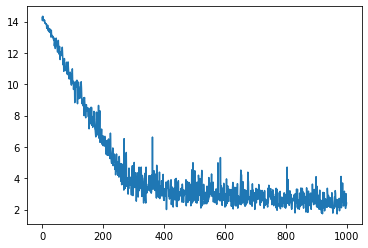

In [149]:
plt.plot(range(epochs), losses)

In [150]:
range(epochs)

range(0, 1000)

# Save model

In [151]:
torch.save(model.state_dict(), 'regression_model_taxi.pt')